# Guess 2/3 of the average

**Inspired by:** Nagel, R. (1995). _Unraveling in guessing games: An experimental study._ The American economic review, 85(5), 1313-1326.

Suppose a newspaper runs a contest. Readers can write in a guess of an integer from 0-100. The editor computes the average of the readers' guesses. The winner is the reader whose guess is closest to 2/3 of the average.

(Before continuing, write down what you would guess!)

The Nash equilibrium for this game is for all readers to guess 0 or 1. However, in practice most people guess a number much higher than that, presumably because they assume that not everyone will play perfectly rationally. This type of game can be used to "unravel" how many levels of cognitive hierarchy people are simulating when playing games.

In this demo, we will model a "level-k" strategy for this game, and then fit the model's predictions to real data collected by the New York Times in order to determine what "level" NYT readers are thinking at.

Let's start with the model.

In [1]:
from memo import memo
import jax.numpy as np
import jax
from matplotlib import pyplot as plt

In [2]:
N = np.arange(100 + 1)  # space of possible guesses
@memo
def player[n: N](level, beta):
    reader: thinks[
        everyone_else: chooses(n in N, wpp=player[n](level - 1, beta) if level > 0 else 1)
    ]
    reader: chooses(n in N, wpp=exp(beta * -abs(n - (2/3) * E[everyone_else.n])))
    return Pr[reader.n == n]

# Timing a level-10 player.
%timeit -r 10 -n 100 out = player(10, 1.0).block_until_ready()

The slowest run took 4.57 times longer than the fastest. This could mean that an intermediate result is being cached.
319 μs ± 249 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)


What does this model predict? A level-0 player guesses around 33 (which is 2/3 of 50, the average if everyone else were guessing randomly), a level-1 player guesses around 22 (which is 2/3 of 33), and so on.

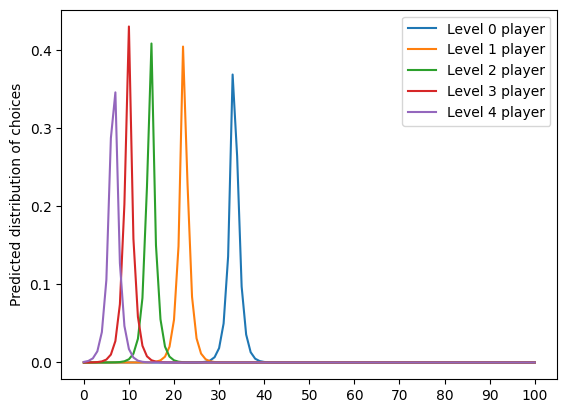

In [3]:
for level in range(5):
    plt.plot(player(level, beta=1.0), label=f'Level {level} player')
plt.xticks(N[::10])
plt.ylabel('Predicted distribution of choices')
plt.legend()

Now let's try to fit this model to some real data. Here is the distribution of 61,139 responses [collected by the New York Times](https://www.nytimes.com/interactive/2015/08/13/upshot/are-you-smarter-than-other-new-york-times-readers.html) in 2015.

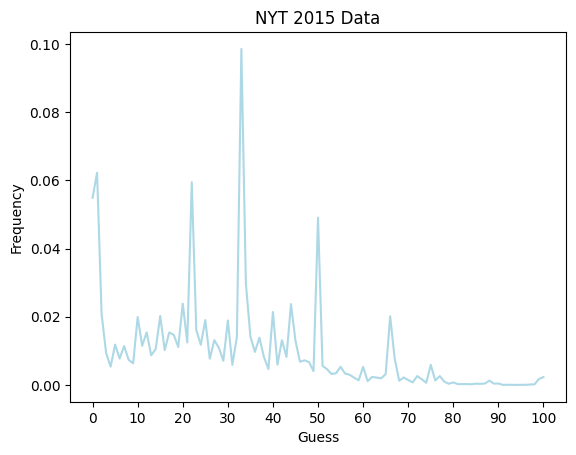

In [4]:
nyt = np.array([198.2332000732422,164.70262145996094,353.80914306640625,406.017822265625,424.3208923339844,394.8409729003906,413.4440612792969,396.7162780761719,415.16937255859375,419.8951416015625,357.85980224609375,396.4162292480469,378.4132385253906,409.1683654785156,400.7669677734375,356.4345703125,402.2672119140625,378.4882507324219,381.7137756347656,397.9914855957031,339.93182373046875,391.9154968261719,177.52975463867188,375.2626953125,395.0660095214844,361.9855041503906,413.6690979003906,388.8399658203125,398.9666748046875,416.51959228515625,362.5105895996094,421.9205017089844,384.86431884765625,-1,313.07733154296875,383.96417236328125,404.59259033203125,385.5394287109375,411.4187316894531,427.4714050292969,351.1836853027344,421.62042236328125,388.8399658203125,411.2687072753906,340.53192138671875,389.7401123046875,417.71978759765625,415.844482421875,418.16986083984375,430.3218994140625,224.93765258789062,423.1957092285156,427.7714538574219,434.14752197265625,433.09735107421875,424.4709167480469,433.54742431640625,435.1226806640625,439.0233459472656,442.6239318847656,424.6209411621094,443.6741027832031,438.0481872558594,439.0233459472656,439.8484802246094,434.44757080078125,356.8846435546875,413.5190734863281,443.1490173339844,438.8733215332031,442.1738586425781,445.3994140625,436.9229736328125,441.1236877441406,445.92449951171875,421.9205017089844,442.7739562988281,436.9229736328125,444.4242248535156,447.19970703125,445.3994140625,447.72479248046875,447.6497802734375,447.6497802734375,447.87481689453125,447.12469482421875,447.3497314453125,446.899658203125,443.0740051269531,447.0496826171875,446.899658203125,448.699951171875,448.5499267578125,448.62493896484375,448.77496337890625,448.62493896484375,448.62493896484375,448.2498779296875,448.02484130859375,440.8236389160156,438.2732238769531,397.9914855957031])[:-1]
nyt = nyt.max() - nyt
nyt = nyt / np.sum(nyt)
plt.plot(nyt, color='lightblue')
plt.xticks(N[::10])
plt.xlabel('Guess')
plt.ylabel('Frequency')
plt.title('NYT 2015 Data')
None

Suppose that NYT readers vary in their levels. We'll fit a categorical distribution over 10 possible levels of readers (0-9), as well as a single $\beta$ parameter across all 10 types of readers.

In [5]:
def pred(fs, beta):
    predictions = sum([f * player(i, beta) for i, f in enumerate(np.exp(fs))])
    predictions = predictions / np.sum(predictions)
    return predictions

def loss(fs, beta):  # mean square error across all N possible guesses
    return np.sum(np.abs(nyt - pred(fs, beta)) ** 2)

fs = np.ones(10)
beta = np.array(1.)
for t in range(200 + 1):
    l, (dfs, dbeta) = jax.value_and_grad(loss, argnums=(0, 1))(fs, beta)
    fs = fs - dfs * 10.0
    beta = beta - dbeta * 10.0
    if t % 50 == 0:
        print(t, l)

print('Best beta =', beta)

0 0.041870005


50 0.015311691


100 0.014830767


150 0.014520813


200 0.014317522
Best beta = 0.65796745


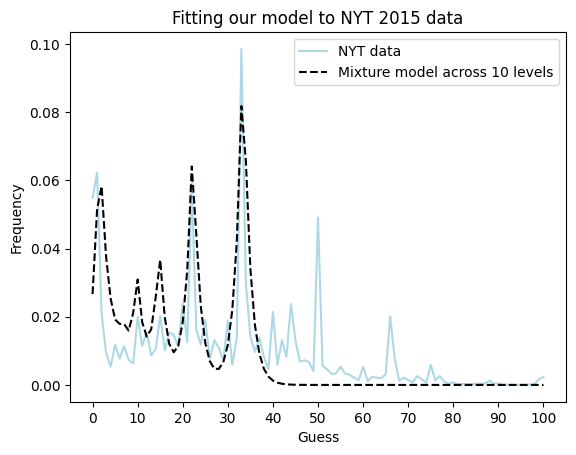

In [6]:
plt.plot(nyt, label='NYT data', color='lightblue')
plt.plot(pred(fs, beta), '--', label=f'Mixture model across {len(fs)} levels', color='black')
plt.legend()
plt.xticks(N[::10])

plt.xlabel('Guess')
plt.ylabel('Frequency')
plt.title('Fitting our model to NYT 2015 data')
None

The model does quite well in capturing the most salient spikes in the data. But it can't explain why anyone would guess 50 or 66. This makes sense: those guesses really do seem irrational. Presumably those readers didn't quite understand how the game works.

Now, by inspecting the fit parameters, we can work out the distribution of levels at which NYT readers are thinking.

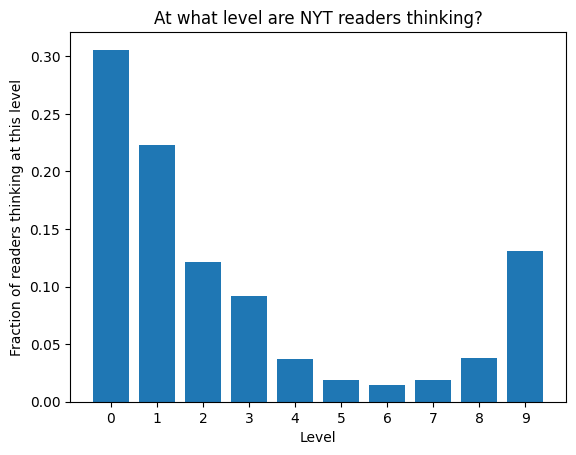

In [7]:
plt.bar(range(len(fs)), np.exp(fs) / np.sum(np.exp(fs)))
plt.ylabel('Fraction of readers thinking at this level')
plt.xlabel('Level')
plt.xticks(range(len(fs)))
plt.title('At what level are NYT readers thinking?')
None

It looks like most readers are thinking at levels 0-3. But about 10% are thinking directly at level 9 (effectively, they have worked out the Nash equilibrium).